# Programming Assignment

Submitted by: Aengus Martin G. Donaire

People I asked help from:

1. Jimson Paulo Layacan 

Websites/resources I used for completing this PA:

1. https://numpy.org/doc/stable/reference/generated/numpy.cov.html
2. https://www.w3schools.com/python/ref_func_zip.asp
3. https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
4. https://www.statology.org/create-table-in-python/

In [1]:
import numpy as np # Numerical Computing
import pandas as pd # Data wrangling
from statistics import NormalDist # statistical analysis
import matplotlib.pyplot as plt #Plotting
from tabulate import tabulate #Tables

# PART 1

In [2]:
def undiversified_d_day_p_percent_VaR_delta_normal(
    df_lst, N_lst, d, p, 
    ewma_par_lst=None
):
    
    """Returns the undiversified d-day p% VaR of a portfolio of stocks using Delta Normal Approach. 
    This function uses the N-day logarithmic returns on a stock level in calculating N-day VaR. 
    
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) dt [str] and (2) closing price [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per stock in the portfolio
    N_lst : list (of int)
        N_i = number of shares for ith stock (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    ewma_par_lst : list (of float)
        ewma_par_i = the value of the lambda parameter in an exponentially-weighted moving average model 
        for ith stock (order should be the same as the order in df_lst) 
        assumes the value is in range (0,1)
        assumes there is no None value in the list
    
    Returns
    -------
    float (2 decimal places)
        undiversified d-day p% VaR of a portfolio of stocks using Delta Normal Approach
    """
    
    #obtain the return column for each df
    def get_return(df):
        """
        df is the original df
        appends returns series to df
        """
        return np.log(df["close"] / df["previous"])

    #obtain the weight column if EWMA model is used
    def get_weights(df,d, ewma_par):
        """
        df is the original df
        appends weight series to df
        """
        count_returns= len(df["close"]) - d                                         #gives the number of non NaN entries
        weight_lst = [ ((1-ewma_par)*(ewma_par)**j) for j in range(count_returns)]  #calculate the weights
        df["weights"] = pd.Series(weight_lst)                                       #attach the weights as a column to the df
        return df
    
    #Case 1: I'll use the VaR with EWMA
    def get_VaR_with_EWMA(df, N , d , p , ewma_par):    #a helper function to compute the VaR (with EWMA) of each stock in the portfolio.
        
        """Returns the d-day 100(alpha)% VaR of a single stock using Delta Normal Approach.
    
        Parameters
        ----------
        df : pandas.DataFrame
            has two columns: (1) dt [str] and (2) closing price [float]
            assumes the dates are arranged from newest to oldest, and the date today is the date on the first row  
        N : int
            number of shares for the sole stock
        d : int
            value of d for the d-day VaR
        p : int
            the value to be used in calculting the 100(alpha)% VaR (e.g. 0.99, 0.95)
        ewma_par : float
            the value of the lambda parameter in an EWMA model for the volatility of the stock
            assumes the value is in the range (0,1)

        Returns
        -------
        float
            d-day 100p% VaR of a single stock using Delta Normal Approach (with EWMA)
        """
        
        s0 = df.loc[0,"close"]                                  #find the recent price of each stock in the portfolio.
        
        df["previous"]= df["close"].shift(-d)                   #shift the closing prices d up to compute the return.
        df["return"] = df.apply(get_return, axis=1)             #compute the return
        
        df = get_weights(df, d, ewma_par)                       #obtain the weights
        variance = np.nansum(df["weights"] * (df["return"]**2)) #compute the variance (weighted)
        sigma = np.sqrt(variance)                               #standard deviation of your stock returns with EWMA 
        quantile = NormalDist().inv_cdf(p)                      #compute for the quantie of p%
        
        var = N * s0 * sigma * quantile                         #compute the VaR under this case
    
        return var
    
    #Case 2: I'll use the normal VaR
    def get_VaR_Normal(df, N ,d, p ):  #a helper function to compute the VaR (without EWMA par) of each stock in the portfolio.
        
        """Returns the d-day 100p% VaR of a single stock using Delta Normal Approach.
    
        Parameters
        ----------
        df : pandas.DataFrame
            has two columns: (1) dt [str] and (2) closing price [float]
            assumes the dates are arranged from newest to oldest, and the date today is the date on the first row  
        N : int
            number of shares for the sole stock
        d : int
            the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)     
        p : int
            the value to be used in calculting the 100(alpha)% VaR (e.g. 0.99, 0.95)
        Returns
        -------
        float (2 decimal places)
            d-day 100p% VaR of a single stock using Delta Normal Approach
        """

        s0 = df.loc[0,"close"]                       #find the recent price of each stock in the portfolio.

        df["previous"]= df["close"].shift(-d)        #shift the closing prices d up to compute the return.
        df["return"] = df.apply(get_return, axis=1)  #compute the return
        
        sigma = df["return"].std()                   #standard deviation of your stock returns without EWMA
        quantile = NormalDist().inv_cdf(p)

        var = N * s0 * sigma * quantile              #compute the VaR under this case
    
        return var                                   #get the var for each stock
    
    if ewma_par_lst != None: #Uses the Case 1 function to sum stock's VaR (EWMA model)
        total = 0            #stores each df's var
        for df, N, ewma in zip(df_lst, N_lst, ewma_par_lst):
            total += get_VaR_with_EWMA(df, N, d, p, ewma)

    else:             #Uses the Case 2 function  (without the EWMA par) to sum stock's VaR
        total = 0     #stores each df's var
        for df, N in zip(df_lst, N_lst):
            total += get_VaR_Normal(df, N, d, p)
    
    return round(total,2)

In [3]:
def diversified_d_day_p_percent_VaR_delta_normal(
    df_lst, N_lst, d, p
    ,ewma_par_lst=None,
    covar_ewma_par=None
):
    
    """Returns the diversified d-day p% VaR of a portfolio of stocks using Delta Normal Approach.
       This function uses the N-day logarithmic returns on a stock level in calculating N-day VaR.
    """  
    """   
    Parameters
    ----------
    df_lst : list of pandas.DataFrame
        each df has two columns: (1) dt [str] and (2) closing price [float]
        assumes the dates are arranged from newest to oldest, and the date today is the date on the first row
        asssumes that all dfs have the same ordered list of dates
        there is one df per stock in the portfolio
    N_lst : list (of int)
        N_i = number of shares for ith stock (order should be the same as the order in df_lst)
    d : int
        the value to be used in calculating the d-day VaR (e.g. 1-day, 5-day)
    p : int
        the value to be used in calculating the p% VaR (e.g. 99, 95)
    ewma_par_lst : list (of float)
        ewma_par_i = the value of the lambda parameter in an exponentially-weighted moving average model 
        for ith stock (order should be the same as the order in df_lst) 
        assumes the value is in range (0,1)
        assumes there is no None value in the list
    covar_ewma_par : float
        the EWMA decay parameter for the covariance of the returns of asset 1 and 2
        
        ** ASSUMPTION: when you want to use EWMA for an N-asset portfolio, this function will only calculate the EWMA 
        for a two-asset portfolio **
    
    Returns
    -------
    float (2 decimal places)
        diversified d-day p% VaR of a portfolio of stocks using Delta Normal Approach
    """
    
    #obtain the return column for each df
    def get_return(df):
        """
        df is the original df
        appends returns series to df
        """
        return np.log(df["close"] / df["previous"])
    
    #obtain the weight column for each df (for EWMA model)
    def get_weights(df,d, ewma_par):
        """
        df is the original df
        appends weight series to df
        """
        count_returns= len(df["close"]) - d #gives the number of non NaN entries
        weight_lst = [ ((1-ewma_par)*(ewma_par)**j) for j in range(count_returns) ] # calculate the weights
        df["weights"] = pd.Series(weight_lst)
        return df
    
    #Obtain the alpha row matrix
    S = np.array([])
    for df in df_lst:
        S=np.append(S, df["close"][0] )
    alpha = np.array(N_lst) * S
    
    #Case 1: I want to use EWMA for 2-asset portfolio
    if len(df_lst) == 2 and len(N_lst) == 2 and ( covar_ewma_par != None) and ( 0 < covar_ewma_par < 1 ) \
        and (ewma_par_lst != None) and ( (min(ewma_par_lst) > 0) and ( max(ewma_par_lst) < 1)):
        
        sigma2 = np.array([])   #storage for the variance of each stock which will be used to construct the variance-covariance matrix
        ret = []                #storage for the return of two stocks which will be used to compute for the covar between two returns
        for df, ewma_par in zip(df_lst, ewma_par_lst):
            
            #a matrix where the return of two stocks are contained
            df["previous"]= df["close"].shift(-d)
            df["return"]=df.apply( get_return, axis=1 )
            ret.append(df["return"]) #this will be used to compute the covariance (with EWMA) below.
            
            #portfolio's variance-covariance matrix
            df = get_weights(df, d, ewma_par)
            variance = np.nansum(df["weights"] * (df["return"]**2))
            sigma2 = np.append(sigma2, variance)  #store each stock's variance (with EWMA model)
        
            dfc   = get_weights(df, d, covar_ewma_par)  #column matrix weights for the covar_ewma_par
   
        covar = np.nansum( dfc["weights"] * (ret[0] * ret[1]) )                    #covariance of the returns of asset 1 and 2 (with EWMA)
        covm = np.array([[sigma2[0], covar],[covar, sigma2[1]]])                   #formation of variance-covariance matrix of the portfolio
        sigmap =  np.sqrt(np.matmul(np.matmul(alpha ,covm),np.transpose(alpha)))   #standard deviation of the portfolio
        
    #Case 2: I don't want to use EWMA for N-asset portfolio
    else:
        ret2= [ ]                                       #store for the return matrix of each of the N stocks
        for df in df_lst:                               #this part will form a matrix of all the returns (same order in df_lst).
            df["previous"]= df["close"].shift(-d)  
            df["return"]=df.apply(get_return, axis=1)
            df = df.dropna()                            #remove the NaN values each stock's returns
            ret2.append(list(df["return"]))             #forming the return matrix for the N-stock portfolio
            
        covm = np.cov(np.array(ret2))                   #variance-covariance matrix for this case
        sigmap = np.sqrt(np.matmul(np.matmul(alpha,covm),np.transpose(alpha)))   #standard deviation of the portfolio
    var = sigmap * NormalDist().inv_cdf(p)
    
    return round(var,2)

# PART 2

### DATA REFERENCE LIST

In [4]:
AC_df   = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/ProgrammingAssignment/main/data/AC.csv")
SM_df   = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/ProgrammingAssignment/main/data/SM.csv")
MFC_df  = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/ProgrammingAssignment/main/data/MFC.csv")
MBT_df  = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/ProgrammingAssignment/main/data/MBT.csv")
GLO_df  = pd.read_csv("https://raw.githubusercontent.com/aengusmartindonaire/ProgrammingAssignment/main/data/GLO.csv")

### QUESTION A

In [5]:
#Portfolio A

df_lstA = [AC_df]
N_lstA = [400]
ewma_par_lstA = [0.70]

In [6]:
#1 Use the delta-normal approach to calculate the portfolio's one-day 95\% VaR.

a1 =undiversified_d_day_p_percent_VaR_delta_normal(df_lstA, N_lstA, 1, 0.95)

print(f"The one-day 95\% VaR of portfolio A is {a1}.")

The one-day 95\% VaR of portfolio A is 813.26.


In [7]:
#2 Use the ten-day logarithmic returns and the delta-normal approach to compute the portfolio's ten-day 95% VaR.

a2 = undiversified_d_day_p_percent_VaR_delta_normal(df_lstA, N_lstA, 10, 0.95)

print(f"The ten-day 95\% VaR of portfolio A is {a2}.")

The ten-day 95\% VaR of portfolio A is 2055.65.


In [8]:
#3 Assume that the one-day volatility of the stock follows an exponentially-weighted moving average model with parameter 𝜆=0.70. 
#  Determine the portfolio's one-day 95% VaR.

a3 = undiversified_d_day_p_percent_VaR_delta_normal(df_lstA, N_lstA, 1, 0.95, ewma_par_lstA)

print(f"The one-day 95\% VaR where stock's volatility follows an EMWA model with 𝜆=0.70 is {a3}.")

The one-day 95\% VaR where stock's volatility follows an EMWA model with 𝜆=0.70 is 272.53.


In [27]:
#Explore and analyze the effect of changing the λ parameter in the resulting VaR.

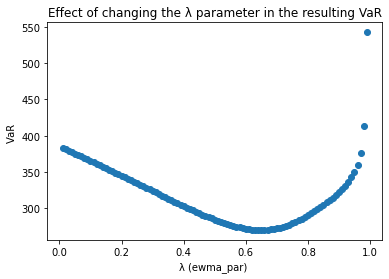

In [10]:
ewma_par = [ round((i+1)*0.01,2) for i in range(0,99) ]

VaR = [ ]  #storage of VaR for a particular λ parameter in ewma_par
for ewma_p in ewma_par:
    VaR.append( undiversified_d_day_p_percent_VaR_delta_normal(df_lstA, N_lstA, 1, 0.95, [ewma_p]) )

plt.scatter( ewma_par , VaR )
plt.xlabel( 'λ (ewma_par) ' )
plt.ylabel( 'VaR ' )
plt.title("Effect of changing the λ parameter in the resulting VaR")
plt.show()

Notice that from λ= 0.01 to λ=0.99 (with increments of 0.01), the resulting VaR initially decreases until λ=0.66 (this was manually inspected). After which, the portfolio's VaR starts to increase. As shown in the **scatter plot** above, the curve of the **VaR** when plotted against λ has parabolic shape (opens upward) where it reaches its minimum VaR (in this set of λ)  at λ=0.66. This means that increasing λ from 0.70 (i.e 0.71, 0.72,...) will also increase the porfolio's VaR while decreasing λ from 0.70 up to 0.66 (i.e 0.69, 0.68,...,0.66) will also decrease the portfolio's VaR. After λ=0.66, the portfolio's VaR will then increase to the left.

### QUESTION B

In [11]:
#Portfolio B

df_lstB = [SM_df, MFC_df]
N_lstB = [500 , 1065]

#Portfolio C
df_lstC = [AC_df, SM_df]
N_lstC = [400 , 500]
ewma_par_lstB = [ 0.87, 0.92 ]
covar_ewma_par = 0.80

In [12]:
#Calculate the undiversified one-day 99\% VaR for Portfolios B.

b_1u = undiversified_d_day_p_percent_VaR_delta_normal(df_lstB, N_lstB, 1, 0.99)
print (f"The undiversified one-day 99\% VaR of portfolio B is {b_1u}.")

The undiversified one-day 99\% VaR of portfolio B is 2959.27.


In [13]:
#Calculate the diversified one-day 99\% VaR for Portfolios B. 

b_2d = diversified_d_day_p_percent_VaR_delta_normal(df_lstB, N_lstB, 1, 0.99)
print (f"The diversified one-day 99\% VaR of portfolio B is {b_2d}.")

The diversified one-day 99\% VaR of portfolio B is 2588.39.


In [14]:
#Calculate the undiversified one-day 99\% VaR for Portfolios C. 

c_3u = undiversified_d_day_p_percent_VaR_delta_normal(df_lstC, N_lstC, 1, 0.99)
print (f"The undiversified one-day 99\% VaR of portfolio C is {c_3u}.")

The undiversified one-day 99\% VaR of portfolio C is 2959.34.


In [15]:
#Calculate the diversified one-day 99\% VaR for Portfolios C. 

c_4d = diversified_d_day_p_percent_VaR_delta_normal(df_lstC, N_lstC, 1, 0.99)
print (f"The diversified one-day 99\% VaR of portfolio C is {c_4d}.")

The diversified one-day 99\% VaR of portfolio C is 2328.36.


In [16]:
#Which portfolio has the higher diversified one-day 99\% VaR? Why? 
#Determine and justify which factor/s contributed to that portfolio having a higher diversified VaR over the other.

In [17]:
col_names1= ["Portfolio", "σ_p (sigmap)","Portfolio Value", "Diversified VaR"]
col_names2=["Stock", "Variance", "Covariance with stock SM"]
port_names = ["B","C"]
sigma_p = [round(1112.6418920001208,2),round(1000.8632642364951,2)]
diverVaR = [ b_2d, c_4d ]
covar = [ 0.00093117, 0.00051984 ]
stock = [ "MFC", "AC" ]
var = [ 0.00057557, 0.00116593 ]
portvalue = [ round(30737.7505197,2), round(24610.000419,2)]

data1= zip(port_names , sigma_p, portvalue, diverVaR)
data2= zip(stock, var,covar)
print(tabulate(data1,headers=col_names1,tablefmt="fancy_grid"))
print(tabulate(data2,headers=col_names2,tablefmt="fancy_grid"))

╒═════════════╤════════════════╤═══════════════════╤═══════════════════╕
│ Portfolio   │   σ_p (sigmap) │   Portfolio Value │   Diversified VaR │
╞═════════════╪════════════════╪═══════════════════╪═══════════════════╡
│ B           │        1112.64 │           30737.8 │           2588.39 │
├─────────────┼────────────────┼───────────────────┼───────────────────┤
│ C           │        1000.86 │           24610   │           2328.36 │
╘═════════════╧════════════════╧═══════════════════╧═══════════════════╛
╒═════════╤════════════╤════════════════════════════╕
│ Stock   │   Variance │   Covariance with stock SM │
╞═════════╪════════════╪════════════════════════════╡
│ MFC     │ 0.00057557 │                 0.00093117 │
├─────────┼────────────┼────────────────────────────┤
│ AC      │ 0.00116593 │                 0.00051984 │
╘═════════╧════════════╧════════════════════════════╛


As shown in the tables above, Porfolio B has a higher diversified VaR with **2588.39**. This can be mainly attributed to **portfolio B's standard deviation (or variance) which is considerably higher than that of Portfolio C.** But computing the portfolio's standard deviation (sigmap) involves the each stock's positions, prices, and the volatility of their returns. Taking this into account, notice that in Portfolio B has a greater **portfolio value** and the covariance between the two stocks in this portfolio covariance is greater than the other two in Portfolio C. Lastly, if we are to consider the stocks of the portfolios, SM is in both portfolios so looking at the variance of the AC and MFC, notice how AC has a higher variance but this was countered by the the higher number of stock (position) by MFC. All of these justified why the diversified VaR of Portfolio B is higher. 

In [18]:
#Consider Portfolio C. Assume that the three-day volatility of each stock and the covariance of their 
#returns follow exponentially weighted moving average models with the given decay parameters above.

#Calculate the undiversified three-day 99\% VaR for Portfolio 

c_5u = undiversified_d_day_p_percent_VaR_delta_normal(df_lstC, N_lstC, 3, 0.99, ewma_par_lstB)
print (f"The undiversified three-day 99\% VaR of portfolio C is {c_5u}.")

The undiversified three-day 99\% VaR of portfolio C is 2041.68.


In [19]:
#Calculate the diversified three-day 99\% VaR for Portfolio 

c_6u = diversified_d_day_p_percent_VaR_delta_normal(df_lstC, N_lstC, 3, 0.99, ewma_par_lstB, covar_ewma_par)
print (f"The diversified three-day 99\% VaR of portfolio C is {c_6u}.")

The diversified three-day 99\% VaR of portfolio C is 1606.69.


### QUESTION C

In [20]:
#Portfolio D

df_lstD = [AC_df, SM_df, MFC_df, MBT_df, GLO_df]
N_lstD = [1381, 2468, 2584, 5160, 3922 ]

In [21]:
#Use the five-day logarithmic returns to determine the portfolio's undiversified VaR.

d_1u = undiversified_d_day_p_percent_VaR_delta_normal(df_lstD, N_lstD, 5, 0.99)
print (f"The undiversified five-day 99\% VaR of portfolio C is {d_1u}.")

The undiversified five-day 99\% VaR of portfolio C is 44046.63.


In [22]:
#Use the five-day logarithmic returns to determine the portfolio's diversified VaR.

d_1d = diversified_d_day_p_percent_VaR_delta_normal(df_lstD, N_lstD, 5, 0.99)
print (f"The diversified five-day 99\% VaR of portfolio C is {d_1d}.")

The diversified five-day 99\% VaR of portfolio C is 34122.39.


In [23]:
#Compute the benefit of diversification.

BoD = round(d_1u - d_1d, 2)
print( f"The benefit of diversification amounts to {BoD}.")

The benefit of diversification amounts to 9924.24.


In [25]:
#Which of the stocks in the portfolio has the highest contribution to the undiversified 5-day 99\% portfolio VaR? Why? 

In [26]:
S = []
for df in df_lstD:
    S=np.append(S, df["close"][0] )
        
sigmas = []
for df in df_lstD:
    def get_return(df):
        return np.log(df["close"] / df["previous"])
    df["previous"]= df["close"].shift(-5)       
    df["return"] = df.apply(get_return, axis=1)
    sigma = df["return"].std()
    sigmas.append(round(sigma,5))
    
VaRs = []
for df,N in zip(df_lstD, N_lstD):
    VaRs.append(undiversified_d_day_p_percent_VaR_delta_normal([df], [N], 5, 0.99))

df_lstDnames = ["AC", "SM", "MFC", "MBT", "GLO"]    
col_names= ["Stock","VaR", "N", "S_0", "sigma"]
data= zip(df_lstDnames , VaRs , N_lstD , S ,sigmas)
print(tabulate(data,headers=col_names,tablefmt="fancy_grid"))

╒═════════╤══════════╤══════╤═══════╤═════════╕
│ Stock   │      VaR │    N │   S_0 │   sigma │
╞═════════╪══════════╪══════╪═══════╪═════════╡
│ AC      │  7656.97 │ 1381 │ 36.2  │ 0.06584 │
├─────────┼──────────┼──────┼───────┼─────────┤
│ SM      │ 20002.3  │ 2468 │ 20.26 │ 0.17196 │
├─────────┼──────────┼──────┼───────┼─────────┤
│ MFC     │  6413.17 │ 2584 │ 19.35 │ 0.05513 │
├─────────┼──────────┼──────┼───────┼─────────┤
│ MBT     │  5045.89 │ 5160 │  9.69 │ 0.04338 │
├─────────┼──────────┼──────┼───────┼─────────┤
│ GLO     │  4928.3  │ 3922 │ 12.75 │ 0.04236 │
╘═════════╧══════════╧══════╧═══════╧═════════╛


#### Note that in the table above, sigma represents the standard deviation of each stock's return.

As can be seen in the table, SM has the highest contribution with 5-day VaR amounting to 20,002.30. Partly, this can be due to the stock price (S_0) which is the second highest among the five stocks in the portfolio. Largely, this can be attributed to volatility (sigma, standard deviation) of SM stock's return which is highest among the five stocks.



In [ ]:
#Compare the individual VaRs and explain which factor/s led to the stock's VaR contribution.

#### With regards to the individual VaR in relation to its contribution to the undiversified portfolio VaR, the following observations are made:

1. AC has the second highest contribution amounting to **7656.97** which, despite having the lowest number of stocks, can be due to the fact that it has the highest stock price (S_0).
2. As mentioned above, SM stock contributed the highest in the undervisified VaR as it has the highest volatility (sigma, standard deviation) and a not so low number of stocks (higher than AC) and relatively higher stock price than most (second highest). Although it has a huge gap with MBT in terms of number of stocks, this was countered by SM having a very high sigma.
3. MFC contributed **6413.17** to the undiversified VaR of the portfolio. Notably, this can be attributed to the combination of higher stock price and standard deviation. Although it has a lower number of stocks than MBT and GLO, these were countered by the two aforementioned feature (stock price and sigma) of stock MFC.
4. MBT posted a VaR of **5045.89** which is the second lower contributor to the undiversified portfolio VaR. Because although it has the highest number of stocks (N), its stock prince and sigma is relatively low than most. In fact, its sigma is as low as the lowest sigma.
5. Lastly, GLO is the lowest contributor **(4928.30)** stock in the portfolio's VaR which is mainly because it has the lowest volatility (sigma). Although it higher than MBT in stock price but the gap in the number of stock between the two is larger causing its VaR to become lower. In comparison with MFC, GLO may have a higher number of stock but both stock price and sigma of GLO is lower hence a lower VaR for GLO. Its lower VaR than SM is obvious since the two are in the opposite sides in sigma with a relatively lower gap in other aspects. Lastly, it still has a lower VaR than AC since it has a much lower stock price despite having a higher number of stocks in the portfolio.